In [1]:
import os
os.chdir('../../scripts')
from analysis_tools_cython import *
from scipy.optimize import curve_fit
from scipy.stats import skewnorm

In [2]:
def gauss2(t,A,t0,sigma):
    """
    Function: Returns the value of a Gaussian distribution at a given time.

    Parameters:
        :t (float or array): Time or array of times at which to evaluate the Gaussian function.
        :A (float): Amplitude of the Gaussian peak.
        :t0 (float): Mean or centre of the Gaussian distribution.
        :sigma (float): Standard deviation or width of the Gaussian distribution.

    Returns:
        float or array: Value of the Gaussian function at the given time(s)."""

    return abs(A)*np.exp( -(t - t0)**2 / (2 * sigma**2) )

def single_gaussian_curve_fit2(x,y):

    assert not (np.isnan(y).any()), "y array contains NaN" 
    assert not (np.isinf(y).any()), "y array contains inf values" 

    """
    Function: Performs a curve fit to the Gaussian function given time and flux.

    Parameters:
        x (array): Independent variable (x-axis) values (time).
        y (array): Dependent variable (y-axis) values (flux).

    Returns:
        params, cov (tuple): The fitted parameters and the covariance matrix."""

    # Initial parameters guess
    i = np.argmax(y)
    A0 = y[i]
    mu0 = x[i]
    sigma0 = (x[-1]-x[0])/4

    params_bounds = [[0,x[0],0], [np.inf,x[-1],sigma0*4]]
    params,cov = curve_fit(gauss,x,y,[A0,mu0,sigma0],bounds=params_bounds)
    return params, cov

def comet_curve2(t,A,t0,sigma,tail):
    """
    Function: Calculates the values of an asymmetric Gaussian function representing a comet curve. 
    The difference is the exponential 1/tail term after the mid-transit.

    Parameters:
        t (array): Independent variable (time) values.
        A (float): Amplitude of the Gaussian curve.
        t0 (float): Mean (centre) of the Gaussian curve.
        sigma (float): Standard deviation of the Gaussian curve.
        tail (float): Tail parameter controlling decay rate after t0.

    Returns:
        array: The computed values of the asymmetric Gaussian curve."""

    x = np.zeros(len(t))
    for i in range(len(t)):
        if t[i] < t0:
            x[i] = gauss(t[i],A,t0,sigma)
        else:
            x[i] = A*math.exp(-abs(t[i]-t0)/tail)
    return x

def comet_curve_fit2(x,y):
    # Initial parameters guess
    # x = time
    # y = flux
    i = np.argmax(y)

    width = x[-1]-x[0]

    params_init = [y[i],x[i],width/3,width/3]

    params_bounds = [[0,x[0],0,0], [np.inf,x[-1],width/2,width/2]]
    params,cov = curve_fit(comet_curve,x,y,params_init,bounds=params_bounds)
    return params, cov

def skewed_gaussian_curve_fit2(x,y,y_err,width):
    """
    Fits a skewed Gaussian curve to the given data points.

    Parameters:
        x (array-like): time.
        y (array-like): lightcurve flux.
        y_err (array-like): Associated errors for lightcurve flux.

    Returns:
        tuple: A tuple containing two elements:
            - params (array-like): The optimized parameters of the skewed Gaussian curve fit.
            - cov (ndarray): The estimated covariance of the optimized parameters.
    """
    
    i = np.argmax(y)
    #width = x[-1]-x[0]
    
    ### params initialisation for skewness, time, mean and sigma
    # amplitude, t0, sigma, skewness
    params_init = [y[i],x[i],width,0]
    
    params_bounds=[[0,x[0],0,-30], [np.inf,x[-1],np.inf,30]]
    params,cov = curve_fit(skewed_gaussian2,x,y,p0=params_init,sigma=y_err,bounds=params_bounds)
    
    return params, cov 

def skewed_gaussian2(x, A, t0, sigma, alpha):
    """
    Skewed Gaussian function using the Skewed Student's t-distribution.

    Parameters:
        x: Input data points.
        A: Amplitude of the Gaussian.
        t0: Mean of the Gaussian.
        sigma: Standard deviation of the Gaussian.
        alpha: Skewness parameter (positive for right-skewed, negative for left-skewed).

    Returns:
        y: The value of the skewed Gaussian at each input data point x.
    """
    y = A * skewnorm.pdf(x,alpha,loc=t0, scale=sigma)
    return y

In [3]:
data, lc_info = import_XRPlightcurve('/storage/astro2/phrdhx/tesslcs/tesslcs_sector_8_104/tesslcs_tmag_12_13/tesslc_183908850.pkl',sector=8)
data = data['time','corrected flux','quality','flux error']

In [4]:
flat_flux, _ = smoothing(data,method='median')

In [5]:
table = Table([data[data.colnames[0]], flat_flux - np.ones(len(flat_flux)), data[data.colnames[2]], data[data.colnames[3]]/np.nanmedian(data[data.colnames[1]])],names=('time','flux','quality','flux_error'))

In [6]:
t, flux, quality, real, flux_error = clean_data(table)
flux *= real

In [7]:
timestep = calculate_timestep(table)
factor = ((1/48)/timestep)
N = len(t)
ones = np.ones(N)

## fourier and Lomb-Scargle computations
A_mag = np.abs(np.fft.rfft(normalise_flux(flux)))

freq, powers = LombScargle(t,flux).autopower() # think about that one
peak_power = powers.max()

## M-statistic
M_stat = calc_mstatistic(flux)

In [8]:
m,n,T1,minT,minT_time,minT_duration,Tm_start,Tm_end,Tm_depth,Ts = run_test_statistic(flux, factor, timestep,t)

### `calc_shape`

In [9]:
def calc_shape2(m,n,time,flux,quality,real,flux_error,n_m_bg_start=3,n_m_bg_scale_factor=1,width=minT_duration):
    """Fit both symmetric and comet-like transit profiles and compare fit.

    original time: time before interpolation step

    Returns:
    (1) Asymmetry: ratio of (errors squared)
    Possible errors and return values:
    -1 : Divide by zero as comet profile is exact fit
    -2 : Too close to edge of light curve to fit profile
    -3 : Unable to fit model (e.g. timeout)
    -4 : Too much empty space in overall light curve or near dip
    -5 : Transit event too close to (before) data gap, within 1.5 days of gap.
    -6 : Transit event too close to (after) data gap, within 1.5 day after gap.
    (2,3) Widths of comet curve fit segments.
    info: t, x, q, fit1 and fit3 are the transit shape elements 

    Asymmetry score, 

    """
    ## how many transit widths to take the general linear trend from. start is 1/4 length of cutout from beginning, end is 1 from end.
    #first_index = n - (n_m_bg_start*n)
    #last_index = n - (n_m_bg_end*m)
    
    
    ## the transit widths of the cutout from the T-statistic minimum value. 
    ## this project requires the cutout to have more transit widths after the midtransit, to cover more of the tail.
    ## default is set to 1 transit width before and 2 transit widths after 

    n_m_bg_end = n_m_bg_scale_factor*n_m_bg_start

    cutout_before = n-(m*n_m_bg_start)
    cutout_after = n+(m*n_m_bg_end)
    
    
    if cutout_before>= 0 and cutout_after < len(time):

        t = time[cutout_before:cutout_after]
        #time_ori = original_time[cutout_before:cutout_after]

        # total time span / (cadence * length of lightcurve)
        if (t[-1]-t[0]) / (np.median(np.diff(t)) * len(t)) > 1.5:
            print(-4)
            return -4,-4,-4,-4,-4,-4,-4, -4
        
        # min time from T-statistic
        t0 = time[n]
        
        ## the time array without interpolation is used to find any data gaps from distance of data points along time axis.
        time_ori = time[real == 1]
        diffs = np.diff(time_ori)
        
        ### if a transit is less than 0.5 days within 2 days before or after transit centre, remove.
        for i,diff in enumerate(diffs):
            if diff > 0.5 and abs(t0-time_ori[i]) < 1.5: 
                return -5,-5,-5,-5,-5,-5,-5,-5
            
            ### after the data gap
            if diff > 0.5 and abs(t0 - time_ori[i + 1]) < 1.5:
                return -6,-6,-6,-6,-6,-6,-6,-6
            

        x = flux[cutout_before:cutout_after]
        q = quality[cutout_before:cutout_after]
        fe = flux_error[cutout_before:cutout_after]
        
        bg_before = np.mean(x[:int(m/4)])
        bg_time_before = np.mean(t[:int(m/4)])
        bg_after = np.mean(x[-int(round(m/4)):])
        bg_time_after = np.mean(t[-int(round(m/4)):])

        grad = (bg_after-bg_before)/(bg_time_after-bg_time_before)
        background_level = bg_before + grad * (t - bg_time_before)
        x = x - background_level
        #x[100:155] = np.median(x)

        try:
            params1, pcov1 = single_gaussian_curve_fit2(t,-x)
            params2, pcov2 = comet_curve_fit2(t,-x)
            params3, pcov3 = skewed_gaussian_curve_fit2(t,-x,fe,width)
        except:
            return -3,-3,-3,-3,-3,-3,-3, -3

        fit1 = -gauss2(t,*params1)
        fit2 = -comet_curve2(t,*params2)
        fit3 = -skewed_gaussian2(t,*params3)
        depth = fit3.min() # depth of comet (based on minimum point; not entirely accurate, but majority of the time true
        #min_time = t[np.argmin(x)] # time of midtransit/at minimum point
        
        
        
        plt.figure(figsize=(10,6))
        plt.plot(t,x)
        plt.plot(t,fit1)
        plt.plot(t,fit2)
        plt.plot(t,fit3,c='black')
        scores = [score_fit(x,fit) for fit in [fit1,fit3]] # changed for the skewed gaussian fit
        if scores[1] > 0:
            skewness_error = np.sqrt(np.diag(pcov3)[3])
            # params3[0] is the amplitude of the gaussian...
            # params3[2] is the sigma/width of the gaussian...
            # params3[3] is the skewness...

            return scores[0]/scores[1], params3[0], params3[2], params3[3], skewness_error, depth, [t,x,q,fe,background_level], [fit1,fit2,fit3]
        
        else:

            return -1,-1,-1,-1,-1,-1,-1, -1
    else:     

        return -2,-2,-2,-2,-2,-2,-2, -2

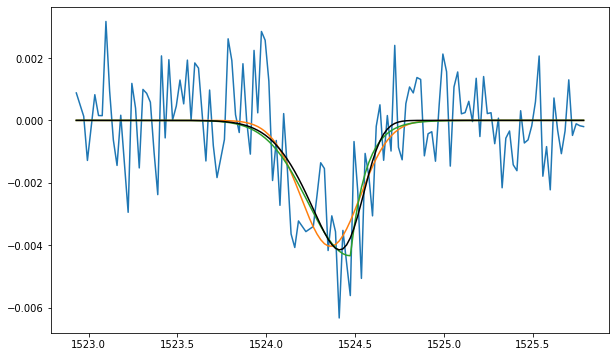

In [10]:
asym, amplitude, width, skewness, skewness_error, depth, info, fits = calc_shape2(m,n,t,flux,quality,real,flux_error,width=minT_duration)